In [1]:
import numpy as np
import scipy.ndimage as nd
import tensorflow.compat.v1 as tf 

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform


In [2]:
model = models.InceptionV1()
model.load_graphdef()

In [3]:
layer_name_list = []
for node in model.graph_def.node:
    layer_name_list.append(node.name)

In [4]:
layer_name_list

['input',
 'conv2d0_w',
 'conv2d0_b',
 'conv2d1_w',
 'conv2d1_b',
 'conv2d2_w',
 'conv2d2_b',
 'mixed3a_1x1_w',
 'mixed3a_1x1_b',
 'mixed3a_3x3_bottleneck_w',
 'mixed3a_3x3_bottleneck_b',
 'mixed3a_3x3_w',
 'mixed3a_3x3_b',
 'mixed3a_5x5_bottleneck_w',
 'mixed3a_5x5_bottleneck_b',
 'mixed3a_5x5_w',
 'mixed3a_5x5_b',
 'mixed3a_pool_reduce_w',
 'mixed3a_pool_reduce_b',
 'mixed3b_1x1_w',
 'mixed3b_1x1_b',
 'mixed3b_3x3_bottleneck_w',
 'mixed3b_3x3_bottleneck_b',
 'mixed3b_3x3_w',
 'mixed3b_3x3_b',
 'mixed3b_5x5_bottleneck_w',
 'mixed3b_5x5_bottleneck_b',
 'mixed3b_5x5_w',
 'mixed3b_5x5_b',
 'mixed3b_pool_reduce_w',
 'mixed3b_pool_reduce_b',
 'mixed4a_1x1_w',
 'mixed4a_1x1_b',
 'mixed4a_3x3_bottleneck_w',
 'mixed4a_3x3_bottleneck_b',
 'mixed4a_3x3_w',
 'mixed4a_3x3_b',
 'mixed4a_5x5_bottleneck_w',
 'mixed4a_5x5_bottleneck_b',
 'mixed4a_5x5_w',
 'mixed4a_5x5_b',
 'mixed4a_pool_reduce_w',
 'mixed4a_pool_reduce_b',
 'mixed4b_1x1_w',
 'mixed4b_1x1_b',
 'mixed4b_3x3_bottleneck_w',
 'mixed4b_3x3

In [5]:
C = lambda neuron: objectives.channel(*neuron)

2024-06-06 11:51:05.271424: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


512 811.62195



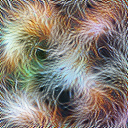

In [6]:
neuron1 = ('mixed4b_pre_relu', 111)  

_ = render.render_vis(model, C(neuron1))